In [40]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from html import unescape
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import glob
import os
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import catboost as cb
from sklearn.model_selection import GridSearchCV

In [6]:
# !pip install pandas numpy scikit-learn catboost optuna

In [7]:
df = pd.read_csv('elon_musk_tweets_labeled.csv')

In [8]:
df = df.drop(['id', 'hashtags', 'user_name', 'user_created', 'is_retweet', 'Unnamed: 0', 'date'], axis=1)

In [9]:
df.head()

,user_location,user_description,user_followers,user_friends,user_favourites,user_verified,text,source,retweets,favorites,feeling_auto
0,NaN,"Mars & Cars, Chips & Dips",101240855,115,13503,True,@BillyM2k I find the gold toe sock – inevitabl...,Twitter for iPhone,335,6542,0
1,NaN,"Mars & Cars, Chips & Dips",101240806,115,13503,True,"Sock Con, the conference for socks",Twitter for iPhone,1451,30753,1
2,NaN,"Mars & Cars, Chips & Dips",101240806,115,13503,True,Always something new for the magazine cover an...,Twitter for iPhone,1284,28610,1
3,NaN,"Mars & Cars, Chips & Dips",101240806,115,13503,True,@ExplainThisBob This guy gets it,Twitter for iPhone,131,3640,1
4,NaN,"Mars & Cars, Chips & Dips",101240806,115,13503,True,Sock tech is so advanced that you can get pret...,Twitter for iPhone,1191,23790,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5904 entries, 0 to 5903
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_location     1050 non-null   object
 1   user_description  1422 non-null   object
 2   user_followers    5904 non-null   int64 
 3   user_friends      5904 non-null   int64 
 4   user_favourites   5904 non-null   int64 
 5   user_verified     5904 non-null   bool  
 6   text              5904 non-null   object
 7   source            5904 non-null   object
 8   retweets          5904 non-null   int64 
 9   favorites         5904 non-null   int64 
 10  feeling_auto      5904 non-null   int64 
dtypes: bool(1), int64(6), object(4)
memory usage: 467.1+ KB


In [11]:
df = pd.get_dummies(df, columns=['user_location'], drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['user_description'], drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['user_verified'], drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['source'], drop_first=True, dtype=int)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5904 entries, 0 to 5903
Data columns (total 20 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   user_followers                                       5904 non-null   int64 
 1   user_friends                                         5904 non-null   int64 
 2   user_favourites                                      5904 non-null   int64 
 3   text                                                 5904 non-null   object
 4   retweets                                             5904 non-null   int64 
 5   favorites                                            5904 non-null   int64 
 6   feeling_auto                                         5904 non-null   int64 
 7   user_location_Boring                                 5904 non-null   int64 
 8   user_location_Hell                                   5904 non-null   int64 
 9

###Data preprocessing & cleaning

In [13]:
df['text'] = df['text'].apply(unescape)

In [14]:
HTML_symbols_check = ['&quot;', '&amp;', '&lt', '&gt;', '&apos;', '&#39;'] #Проверяем, что HTML-cущности заменены на соответствующие символы

for symbol in HTML_symbols_check:
    if df['text'].str.contains(symbol).any():
        print(f"Символ '{symbol}' найден в датасете.")
    else:
        print(f"Символ '{symbol}' не найден в датасете.")

Символ '&quot;' не найден в датасете.
Символ '&amp;' не найден в датасете.
Символ '&lt' не найден в датасете.
Символ '&gt;' не найден в датасете.
Символ '&apos;' не найден в датасете.
Символ '&#39;' не найден в датасете.


In [15]:
df['text'] = df['text'].str.replace(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', regex=True) #Удаляем emails
df['text'] = df['text'].str.replace(r'@([A-Za-z0-9_]{1,})', '', regex=True) #Удаляем ники
df['text'] = df['text'].str.replace(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', '', regex=True) #Удаляем urls

In [16]:
df['text'] = df['text'].str.lower()

In [17]:
df['text'] = df['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True) #Удаляем знаки препинания и цифры и оставляем только буквы и пробелы

In [18]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()  #Удаляем лишние пробелы

###Токенизация

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [20]:
df['tokens'] = df['text'].apply(word_tokenize)

In [21]:
df['tokens']

,tokens
0,"[i, find, the, gold, toe, sock, inevitably, of..."
1,"[sock, con, the, conference, for, socks]"
2,"[always, something, new, for, the, magazine, c..."
3,"[this, guy, gets, it]"
4,"[sock, tech, is, so, advanced, that, you, can,..."
...,...
5899,"[hes, not, wrong]"
5900,"[guys, i, think, i, maybe, took, too, much]"
5901,[cool]
5902,"[time, to, complete, the, circle]"


###Удаление стоп-слов

In [22]:
def delete_stopwords(tokens):
    cleaned = []
    for word in tokens:
        if word not in stop_words:
            cleaned.append(word)
    return cleaned

df['cleaned_tokens'] = df['tokens'].apply(delete_stopwords)

###Лемматизация

In [23]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
def lemmatize_tokens(tokens):
    lemmatized = []
    for word in tokens:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

df['lemmatized'] = df['cleaned_tokens'].apply(lemmatize_tokens)

In [25]:
df['lemmatized'] = df['lemmatized'].apply(' '.join)

In [26]:
df = df.drop(['text', 'tokens', 'cleaned_tokens'], axis=1)

###Bag-of-Words

In [27]:
df.head()

,user_followers,user_friends,user_favourites,retweets,favorites,feeling_auto,user_location_Boring,user_location_Hell,user_location_Trøllheim,user_location_Twitter HQ,user_location_Twitter NY,"user_description_Mars & Cars, Chips & Dips",user_description_Perfume Salesman,user_description_State-Affiliated Media,user_description_Twitter Complaint Hotline Operator,user_description_handsome/brilliant,user_description_nothing,user_verified_True,source_Twitter for iPhone,lemmatized
0,101240855,115,13503,335,6542,0,0,0,0,0,0,1,0,0,0,0,0,1,1,find gold toe sock inevitably kilter washed li...
1,101240806,115,13503,1451,30753,1,0,0,0,0,0,1,0,0,0,0,0,1,1,sock con conference sock
2,101240806,115,13503,1284,28610,1,0,0,0,0,0,1,0,0,0,0,0,1,1,always something new magazine cover article pr...
3,101240806,115,13503,131,3640,1,0,0,0,0,0,1,0,0,0,0,0,1,1,guy get
4,101240806,115,13503,1191,23790,1,0,0,0,0,0,1,0,0,0,0,0,1,1,sock tech advanced get pretty much anything so...


In [28]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['lemmatized'])

vocab = vectorizer.get_feature_names_out()
len(vocab)

6103

In [29]:
df.shape

(5904, 20)

In [30]:
bow_df = pd.DataFrame(X.toarray(), columns=vocab)

final_df_bow = pd.concat([df, bow_df], axis=1)
final_df_bow.head()

,user_followers,user_friends,user_favourites,retweets,favorites,feeling_auto,user_location_Boring,user_location_Hell,user_location_Trøllheim,user_location_Twitter HQ,...,zeal,zealand,zero,zerohedge,zip,zombie,zone,zoolander,zoom,zuck
0,101240855,115,13503,335,6542,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,101240806,115,13503,1451,30753,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,101240806,115,13503,1284,28610,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,101240806,115,13503,131,3640,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,101240806,115,13503,1191,23790,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###TF-IDF

In [31]:
tfidf_vectorizer = TfidfVectorizer()

X_tfidf = tfidf_vectorizer.fit_transform(df['lemmatized'])

feature_names = tfidf_vectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)
df_final_tfidf = pd.concat([df, df_tfidf], axis=1)

df_final_tfidf.head()

,user_followers,user_friends,user_favourites,retweets,favorites,feeling_auto,user_location_Boring,user_location_Hell,user_location_Trøllheim,user_location_Twitter HQ,...,zeal,zealand,zero,zerohedge,zip,zombie,zone,zoolander,zoom,zuck
0,101240855,115,13503,335,6542,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101240806,115,13503,1451,30753,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101240806,115,13503,1284,28610,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101240806,115,13503,131,3640,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,101240806,115,13503,1191,23790,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###ML part for BOW

In [32]:
X = final_df_bow.drop(['feeling_auto', 'lemmatized'], axis=1)
y = final_df_bow['feeling_auto']

In [33]:
X.shape

(5904, 6121)

In [34]:
scaler = StandardScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.2, random_state=42)

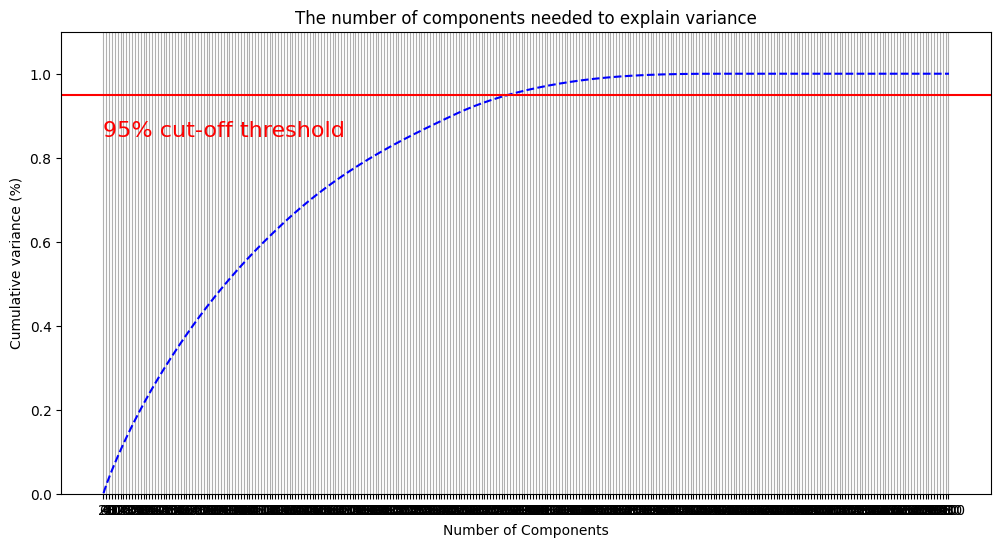

In [34]:
pca = PCA().fit(scaled_data)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 5905, step=1)
y_axe = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y_axe, linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5904, step=20))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [35]:
# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)

In [36]:
X_pca.shape

(5904, 2831)

In [37]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [38]:
import optuna

def objective(trial):
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15, log=True),
        "depth": trial.suggest_int("depth", 1, 5),
        # "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 7),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostClassifier(**params, silent=True, random_seed=42)
    model.fit(X_train_pca, y_train_pca)
    predictions = model.predict(X_test_pca)
    roc_auc_metric = roc_auc_score(y_test_pca, predictions)
    return roc_auc_metric

In [39]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2024-12-06 23:57:38,465] A new study created in memory with name: no-name-2ce09784-cad0-4cda-808a-4be7ee00573f
[I 2024-12-06 23:59:00,744] Trial 0 finished with value: 0.6739899680802554 and parameters: {'learning_rate': 0.06978635406435697, 'depth': 2}. Best is trial 0 with value: 0.6739899680802554.
[I 2024-12-07 00:02:01,168] Trial 1 finished with value: 0.6971500227998175 and parameters: {'learning_rate': 0.13668190212399217, 'depth': 4}. Best is trial 1 with value: 0.6971500227998175.
[I 2024-12-07 00:04:55,134] Trial 2 finished with value: 0.6839002887976897 and parameters: {'learning_rate': 0.08018803023316351, 'depth': 4}. Best is trial 1 with value: 0.6971500227998175.
[I 2024-12-07 00:06:50,669] Trial 3 finished with value: 0.6803936768505852 and parameters: {'learning_rate': 0.13435941670620766, 'depth': 3}. Best is trial 1 with value: 0.6971500227998175.
[I 2024-12-07 00:09:49,841] Trial 4 finished with value: 0.7036464508283934 and parameters: {'learning_rate': 0.129714

In [41]:
print('Best hyperparameters:', study.best_params)
print('Best roc_auc:', study.best_value)

Best hyperparameters: {'learning_rate': 0.12971423410185118, 'depth': 4}
Best roc_auc: 0.7036464508283934


In [45]:
params = {
    'iterations': [500],
    'learning_rate': [0.01, 0.1],
    'depth': [2, 4],
    # 'l2_leaf_reg': [2, 3],
    # 'loss_function': ['Logloss', 'CrossEntropy'],
    # 'loss_function': ['Logloss'],
    # 'logging_level': ['Silent'],
    # 'random_seed': [42]
}

In [46]:
model = CatBoostClassifier()

In [47]:
%%time
grid_search = GridSearchCV(model, params, scoring='roc_auc', cv=3)

grid_search.fit(X_train_pca, y_train_pca)


print(grid_search.best_params_)


auc_score = grid_search.score(X_test_pca, y_test_pca)
print(f'AUC: {auc_score}')

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.6610953	total: 546ms	remaining: 54s
5:	learn: 0.6555422	total: 668ms	remaining: 55s
6:	learn: 0.6512804	total: 772ms	remaining: 54.4s
7:	learn: 0.6469597	total: 881ms	remaining: 54.2s
8:	learn: 0.6424947	total: 987ms	remaining: 53.9s
9:	learn: 0.6393264	total: 1.09s	remaining: 53.6s
10:	learn: 0.6361258	total: 1.2s	remaining: 53.4s
11:	learn: 0.6343101	total: 1.31s	remaining: 53.2s
12:	learn: 0.6310358	total: 1.41s	remaining: 52.9s
13:	learn: 0.6279310	total: 1.53s	remaining: 53.1s
14:	learn: 0.6263232	total: 1.65s	remaining: 53.3s
15:	learn: 0.6244006	total: 1.76s	remaining: 53.2s
16:	learn: 0.6230673	total: 1.86s	remaining: 52.9s
17:	learn: 0.6211303	total: 1.97s	remaining: 52.7s
18:	learn: 0.6195614	total: 2.07s	remaining: 52.4s
19:	learn: 0.6183451	total: 2.17s	remaining: 52.1s
20:	learn: 0.6169572	total: 2.28s	remaining: 52.1s
21:	learn: 0.6156868	total: 2.39s	remaining: 51.8s
22:	learn: 0.6131901	tota